In [1]:
import pickle
import pandas as pd

from src.utils.Director_Actor import *
from src.utils.langue import *
from src.utils.career import *
from src.utils.plot import *

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# P3 : Directors and actors

This notebook will present all the main results of the analysis of the final axis of the project. This axis is directed towards the relationship between actors and directors.

The directors of each movie were previously found with the IMDb dataset. Only a little information about each director was found, such as date of birth/death, name, as well as the list of movies they directed. Nevertheless, we will extract additional information about each directors with the films.

The goal of this part would be to link actors who were successful during their career to directors using a bipartite directed graph. The directed graph would be from the actor to the director. The weight of each edge would be the number of movies where the actor and the director were together. The value at the node of the director would be the sum of the weight of each edge coming to him. By doing so, we hope to analyse the link between successful actors and directors and see if directors who have higher value have better careers and what are the factors that help them achieve these high counts. In order to quantify the successfulness of an actor, multiple criteria were applied to each actors : such as number of films, average ratings, average ratings per genre, centrality and degree of node. They will be better explained throughout this section. 

The two major research questions of this line of analysis would be:
1. **What made an actor successful ?**
2. **What are the type of directors that are linked to successful actors ?**

Here is the global strategy that we will use to answer these questions:
1. Pre-process some data (specific way for this section as there is now directors)
2. Compute metrics about actors and their network
3. Analyse the metrics to determine who and what is a successful actor
4. Create a directed bipartite network between successful actors and directors
5. Apply a Kmeans algorithm to the list of directors
6. Analyse and compares the directors between them (through plot an metrics)
7. Determine the type of directors and analyse specific directors to illustrate

## 0. Loading Value

In [3]:
movie_path = 'data/Movie.pkl'
actors_path = 'data/Actor.pkl'

with open(movie_path, 'rb') as file:
    Movie = pickle.load(file)

with open(actors_path, 'rb') as file:
    Actor = pickle.load(file)

In [4]:
print(f'Shape of Actor :{Actor.shape}')
print(f'Shape of Movie :{Movie.shape}')

Shape of Actor :(135760, 8)
Shape of Movie :(61042, 26)


In [5]:
Movie.head()

IMDb_title_ID  release_date runtime  \
1894missjerry                      tt0000009          1894      45   
1897thecorbettfitzsimmonsfight     tt0000147          1897     100   
1906thestoryofthekellygang         tt0000574          1906      70   
1908hamlet                         tt0000630          1908    <NA>   
1908thefairylogueandradioplays     tt0000679          1908     120   

                                                 Primary_title  \
1894missjerry                                       Miss Jerry   
1897thecorbettfitzsimmonsfight   The Corbett-Fitzsimmons Fight   
1906thestoryofthekellygang         The Story of the Kelly Gang   
1908hamlet                                              Hamlet   
1908thefairylogueandradioplays  The Fairylogue and Radio-Plays   

                                                Original_title Average rating  \
1894missjerry                                       Miss Jerry            5.4   
1897thecorbettfitzsimmonsfight   The Corbett-Fitzsimmons Fight            5.2   
1906thestoryofthekellygang         The Story of the Kelly Gang            6.0   
1908hamlet                                              Amleto            3.1   
1908thefairylogueandradioplays  The Fairylogue and Radio-Plays            5.2   

                               number of votes     IMDb_director_ID  \
1894missjerry                            216.0            nm0085156   
1897thecorbettfitzsimmonsfight           540.0            nm0714557   
1906thestoryofthekellygang               938.0            nm0846879   
1908hamlet                                30.0            nm0143333   
1908thefairylogueandradioplays            77.0  nm0091767,nm0877783   

                                    IMDb_writers_ID  \
1894missjerry                             nm0085156   
1897thecorbettfitzsimmonsfight                 <NA>   
1906thestoryofthekellygang                nm0846879   
1908hamlet                                nm0000636   
1908thefairylogueandradioplays  nm0000875,nm0877783   

                                             Producer name  ...  \
1894missjerry                              Alexander Black  ...   
1897thecorbettfitzsimmonsfight             Enoch J. Rector  ...   
1906thestoryofthekellygang                    Charles Tait  ...   
1908hamlet                                  Mario Caserini  ...   
1908thefairylogueandradioplays  Francis Boggs, Otis Turner  ...   

                               Wikipedia_movie_ID Freebase_movie_ID  \
1894missjerry                            10109752        /m/02q23xk   
1897thecorbettfitzsimmonsfight           28703057        /m/0czdh_n   
1906thestoryofthekellygang                 142995         /m/0120y4   
1908hamlet                               15128675        /m/03hjcy9   
1908thefairylogueandradioplays            5954041         /m/0fgfyy   

                                                    Movie_name  \
1894missjerry                                       Miss Jerry   
1897thecorbettfitzsimmonsfight   The Corbett-Fitzsimmons Fight   
1906thestoryofthekellygang         The Story of the Kelly Gang   
1908hamlet                                              Hamlet   
1908thefairylogueandradioplays  The Fairylogue and Radio-Plays   

                               Movie_release_date Movie_box_office_revenue  \
1894missjerry                                1894                     <NA>   
1897thecorbettfitzsimmonsfight               1897                 100000.0   
1906thestoryofthekellygang                   1906                     <NA>   
1908hamlet                                   1908                     <NA>   
1908thefairylogueandradioplays               1908                     <NA>   

                               Movie_runtime   Movie_languages  \
1894missjerry                           <NA>       Silent film   
1897thecorbettfitzsimmonsfight          <NA>                     
1906thestoryofthekellygang              70.0  English Language   
1908haml

In [6]:
Actor.head()

Freebase_actor_ID      actor_name   actor_DOB actor_gender actor_height  \
0          /m/010p3    Adam Carolla  1964-05-27            M         1.88   
1         /m/010q36     Fred Rogers  1928-03-20            M          NaN   
2          /m/010wx   Aria Giovanni  1977-11-03            F         1.68   
3         /m/010xjr  Richard Harris  1930-10-01            M         1.85   
4         /m/0112yl  Toshiro Mifune  1920-04-01            M         1.74   

           ethnicity                                  Freebase_movie_ID  \
0  Italian Americans  [/m/0bq2wj, /m/08hjr9, /m/06zm9p7, /m/06c5z_, ...   
1               None                                        [/m/033pf1]   
2          Yugoslavs                                        [/m/07gx0c]   
3       Irish people  [/m/0c_6bf, /m/078mm1, /m/03qfyt, /m/0cz7_4w, ...   
4               None  [/m/0513nd, /m/05c2g3q, /m/04wjg1, /m/01tch8, ...   

                            actor_age_atmovierelease  
0  [35.0, 35.0, 45.0, 33.0, 33.0, 34.0, 42.0, 35....  
1                                             [67.0]  
2                                             [25.0]  
3  [66.0, 46.0, <NA>, 59.0, 48.0, 39.0, 66.0, 50....  
4  [31.0, 42.0, 45.0, 41.0, 62.0, 29.0, 30.0, 38....

In [7]:
Director = create_Director_profile(Movie)
Director.head()

IMDb_director_ID     director_name  birthYear_director deathYear_director  \
0        nm0000005    Ingmar Bergman              1918.0               2007   
1        nm0000008     Marlon Brando              1924.0               2004   
2        nm0000009    Richard Burton              1925.0               1984   
3        nm0000018      Kirk Douglas              1916.0               2020   
4        nm0000019  Federico Fellini              1920.0               1993   

                                   Freebase_movie_ID  \
0  [/m/02r9cv1, /m/05nrqp, /m/05ppr_, /m/027yppr,...   
1                                        [/m/02616b]   
2                                        [/m/095s_p]   
3                           [/m/04f5xbz, /m/0h3ph1j]   
4  [/m/09rwr0, /m/0b0gjq, /m/09sgmx, /m/074x3d, /...   

                                age_at_movie_release  
0  [28.0, 28.0, 29.0, 30.0, 30.0, 31.0, 31.0, 32....  
1                                             [37.0]  
2                                             [42.0]  
3                                       [59.0, 57.0]  
4  [30.0, 33.0, 33.0, 34.0, 40.0, 42.0, 43.0, 45....

## 1. Pre-processing of the data

In this section, we will apply the previously defined function in order to gain more information about our dataframe. Information such as the starting age of the career or the number of films played per genre will be computed using others informations in the respective dataframe of the actors and directors.

An important additional note is that throughout the notebook, the metrics related to actors will only be calculated for actors which played in at least 5 movies. This also applies for later when the bipartite network between actors and film for actors will be computed. This is justified and motivated by the following reasons :</br>
Firstly, it is that being in at least 5 movies can be considered as a characterics that is common to successfull actors. Indeed, a "true" actor will not only participate in 2 or 3 movies if he plan on having a career. His goal would be to participate in multiple movies.</br>
Secondly, an actor which only participate in one movie is pretty common. Adding an actor which only played in one movie is not relevant as this person may have been a figurant in a movie and hence is not really part of the film industry. This is not relevant with the aspect of our study.</br>
Finally, it also reduce the necessary computing time of the code. Computing the network of all actors through their relation based on their movie can be rather long and if not information can be obtained for actors who only participate in one movie then it is not worth to add them to the network.

Later on, as we determine what are the characteristics of a successful actor, this threshold may be updated and increased. This same process will not be applied to the directors because the purpose is to determine the successfull directors in function of the actors. Hence, the list of directors will be found from the remaining actors. Nevertheless, new characterics will also be added to the directors and some directors may be dropped due to lack of information about them. 

In [8]:
# Applying different functions to the actor and director in order to obtain new information 
Actor_copy = Actor.copy()

# Computing the starting age of their career
Actor_copy = add_start_age(Actor_copy, person_type='actor')
Director = add_start_age(Director, person_type='director')

# Computing the number of films in which the actor played
Actor_copy = add_film_count(Actor_copy, person_type='actor')
Director = add_film_count(Director, person_type='director')

# Finding the ratings of all of their movies
Actor_copy = add_ratings(Actor_copy, Movie, person_type='actor')
Director = add_ratings(Director, Movie, person_type='director')

# Computing their mean rating based on their movies
Actor_copy = compute_mean_rating(Actor_copy)
Director = compute_mean_rating(Director)

In [9]:
# Verifying the number of missing values
print(f"The total number of actors is : {Actor_copy.shape[0]}")
print(f"The total number of missing values in each column is :")
Actor_copy.isna().sum()

The total number of actors is : 135760
The total number of missing values in each column is :


Freebase_actor_ID                0
actor_name                     338
actor_DOB                    77187
actor_gender                 38377
actor_height                122904
ethnicity                   127865
Freebase_movie_ID                0
actor_age_atmovierelease         0
Career_Start_age             83923
Number_of_films                  0
Ratings                          0
Mean_Rating                  40422
dtype: int64

In [10]:
# Verifying the number of missing values
print(f"The total number of directors is : {Director.shape[0]}")
print(f"The total number of missing values in each column is :")
Director.isna().sum()

The total number of directors is : 23518
The total number of missing values in each column is :


IMDb_director_ID            0
director_name               0
birthYear_director       9884
deathYear_director          0
Freebase_movie_ID           0
age_at_movie_release        0
Career_Start_age        10340
Number_of_films             0
Ratings                     0
Mean_Rating              2245
dtype: int64

In [11]:
# Filter actors who have played in at least 5 films
Actor_5 = Actor_copy[Actor_copy['Number_of_films'] >= 5]

# Verifying the number of missing values
print(f"The total number of actors which played in 5 films is : {Actor_5.shape[0]}")
print(f"This represents {Actor_5.shape[0]/Actor.shape[0]:.2%} of the total numbers of actors")
print(f"The total number of missing values in each column is for this new dataframe is :")
Actor_5.isna().sum()

The total number of actors which played in 5 films is : 19472
This represents 14.34% of the total numbers of actors
The total number of missing values in each column is for this new dataframe is :


Freebase_actor_ID               0
actor_name                      6
actor_DOB                    1607
actor_gender                  217
actor_height                12318
ethnicity                   15149
Freebase_movie_ID               0
actor_age_atmovierelease        0
Career_Start_age             3332
Number_of_films                 0
Ratings                         0
Mean_Rating                 13542
dtype: int64

A lot of actors were dropped from the dataframe, as expected. As a comparaison, even by keeping only the actors which have played in at least two movies, the total proportion that is kept from the original dataframe is only 36%. As can be seen, by dropping actors which did not played in a lot of movies, a lot less values are missing from each of the columns meaning that the actors which played in more movies have more information about them available. This is good as doing analysis on empty columns would be less interesting and harder.</br>
As can be seen there are less values missing in the director dataframe. This was expected as every directors is "important", on the oppostite, actors can be figurant and hence less informations are known about them.

We will now compute the number of movies per genre and also their ratings as well as the number of movies per genre per actor and their ratings depending on the genre. This will also be done for the directors. This is motivated by the fact that depending on the genre, the average ratings may be below or above the total average (for example, comedic films tends to have lower ratings, nevertheless famous comedic actors can still be considered successfull despite a low ratings). Based on this fact, if we want to use the metrics of the ratings to determine the relative success of an actors with respect to its genre, we also need its ratings per genre. This will also help determine what specific genre of movies is an actor related to. Some actors only do action or drama or comedic movies. The same reflexion can be made for the directors

In [12]:
# Computing the metrics related to the number of movie per genre and number of film per genre per actor
start_time = time.time()

# Computing the top genre of each actor and their rating in that genre
Actor_Top_genre = Actor_genre_count_ratings(Actor_5, Movie,min_movies=5)

# Computing the top genre of each director and their rating in that genre
Director_Top_genre = Director_genre_count_ratings(Director, Movie,min_movies=1)

# Computing the rating of each genre and the number of movies per genre
Genre_counts = Number_per_genre(Movie, Min_movie=0)

# Printing the results
print(f"The total number of genres is : {Genre_counts.shape[0]}")
print(f"The total number of movies is : {Movie.shape[0]}")

end_time = time.time()
print(f"Computation time : {time.time()-start_time:.2f}")

The total number of genres is : 361
The total number of movies is : 61042
Computation time : 49.32


In [13]:
Genre_counts.head()

Movie_genres  Count  Average rating
0         Drama  28914        6.397012
1        Comedy  12561        6.085487
2  Romance Film   9255        6.235040
3        Action   7468        5.849952
4      Thriller   7333        5.950014

In [14]:
Actor_Top_genre.head()

Top_1_Genre Top_1_Number  Top_1_Rating
Freebase_actor_ID                                            
/m/010p3              Romance Film            8      5.000000
/m/010xjr                Adventure           33      6.568421
/m/0112yl          Japanese Movies           36      7.476471
/m/011_3s                    Drama           26      6.444444
/m/011_c4            Crime Fiction            7      6.666667

We will now dropped the actors and directors which we do not know their top genre.

In [15]:
# Merging the results and dropping the row where there is no top genre 
print(f"There was {Actor_5.shape[0]} actors.")
Actor_5 = Actor_5.merge(Actor_Top_genre, how='inner', left_on='Freebase_actor_ID', right_index=True)
print(f"There is now {Actor_5.shape[0]} actors after merging and dropping the row where the top genre was not known.")

There was 19472 actors.
There is now 19322 actors after merging and dropping the row where the top genre was not known.


In [16]:
# Merging the results and dropping the row where there is no top genre 
print(f"There was {Director.shape[0]} directors.")
Director = Director.merge(Director_Top_genre, how='inner', left_on='IMDb_director_ID',right_index=True)
print(f"There is now {Director.shape[0]} directors after merging and dropping the row where the top genre was not known.")

There was 23518 directors.
There is now 23518 directors after merging and dropping the row where the top genre was not known.


As can be seen from the computation of the ratings per genre, there is 361 different genres of movies. This is quite large and some genre are quite specific (for example there is LGBTQ, Gay and Gay interest but all Gay and Gay interest are also labelled as LGBTQ). In addition to that, some movies possessed multiple genres, certain 5 others only 1. Due to these reasons, it was decided to only considers the genre where there was at least a specific number of movies.</br>
By doing so, only the most relevant and "common/basic" genres will be kept. This will facilitate the analysis in order to determine the successfullness of an actor and the "type of actor" they are. In order to determine the right threshold, the elbow method was applied.

In [17]:
# Applying the elbow method
Elbow_method_genre(Movie)

As can be seen from the plot above, the elbow happens between 150 and 200 movies. Consequently, it was decided to only keep the genre with more than 200 movies

In [18]:
# Computing the final number of genres for 200 films
Genre_counts_200 = Number_per_genre(Movie, Min_movie=200)
print(f"There is {Genre_counts_200.shape[0]} genres with at least 200 movies")
Genre_counts_200.head(10)

There is 94 genres with at least 200 movies


Movie_genres  Count  Average rating
0            Drama  28914        6.397012
1           Comedy  12561        6.085487
2     Romance Film   9255        6.235040
3           Action   7468        5.849952
4         Thriller   7333        5.950014
5     World cinema   6759        6.470132
6  Black-and-white   6501        6.455730
7    Crime Fiction   6154        6.196113
8            Indie   4753        6.106063
9        Adventure   4096        5.979210

We must now verify that each actor in `Actor_5` has their primary genre also in our list of genres from the elbow method. 

In [19]:
Actor_final, Director_final = Final_Pre_processing(Actor,Actor_5,Director,Genre_counts_200)

In the end, we have 18967 actors and 17094 directors .


We can now compute the final dataset of actors that will be used to determine wether or no they are successfull. 

## 2. Computings metrics

As mentionned previously, in order to determine when and how is an actor successful, multiple metrics will be computed in order to quantify this aspect. Here is a list of the metrics that we will be computing to help us determine the success of an actor : 
- Number of films played : the number of films played by the actor is important, a minimum threshold should be applied as an actor which only played in one movie is not relevant. The more an actor played means the more people are willing to work with him and also that he is good at what he does. In addition to that, it also prevents from taking into account actors which only participate in 2-3 movies as figurant and did not have a career nor were really part of the film industry. This was mostly done in the previous with taking into account only actors that have played in at least 5 movies, nevertheless it is possible that an even higher threshold is applied.

- Number of edge (degree of a node) : potentially, a threshold should also be applied on the number of edge. This is important as a successfull actor should theoritically have a lot of relation due to the length of his career and the number of movies he played. Nevertheless, this value is linked with the number of movies in which the actor played. Indeed, the more the actor played in a movie, the more edge his node should have. Hence this constraints could overlap with the one on the number of films played. In addition to that, an actor could play in a lot of movies which do not contains a lot of actor, hence he would not have a lot of edge despite having played in quite a number of movies.

- Centrality in a network : The centrality of a node in a network is quite an important metrics, it refers to the idea that a node in a graph is more central if it is connected to other important nodes. We will be using closeness centrality and eigenvector centrality in order to compute this metric. Eigenvector centrality is proportional to a location near the most significant nodes or communities in the graph. (https://www.sciencedirect.com/topics/computer-science/eigenvector-centrality)

- Comparaison of the average rating of the actor and the average ratings global and per genre : the average rating of the actors as well as his rating depending of the genre of movie in which he played will also be analysed. If his average ratings per genre is superior to a certain proportion, then it can be assumed that he is a talented actor.

### 2.1 Network for actors with at least 5 films

We will now compute the network for actors which played in at least 5 movies. After that, different metrics of the network will be computed such as the degree of the node and its eigenvector centrality.

In [20]:
# Create the network of the actors if they played together and compute atrtibutes from the network
# Add these attrbiutes (degree of the node, eigenvector centrality) to the Actor
played_together, Actor_final = Create_Network_Actor_and_Attribute(Actor_final,Movie,min_movie=5)

Computation time:20.05


## 3. What is a successful actor

Now that all the different metrics were computed, it is possible to determine what is a successfull actors and what are his characteristics. As explained previously, this will be done by comparing the metrics. First of all, it is necessary to compare the value of the metrics between the actors in order to determien threshold. The metrics : 
- Number of films played 
- Number of edge (degree of a node) 
- Centrality in a network (eigenvector, closeness) 
- Comparaison of the average rating of the actor and the average ratings global and per genre

It is important to keep in mind that some of the metrics below are only shown for actors that played at least in 5 movies. This means that the actor below are already in "the top" 15%, as actors with less than 5 movies represented 85% of the orginal dataset.

### 3.1 Degrees of an actor and number of films played

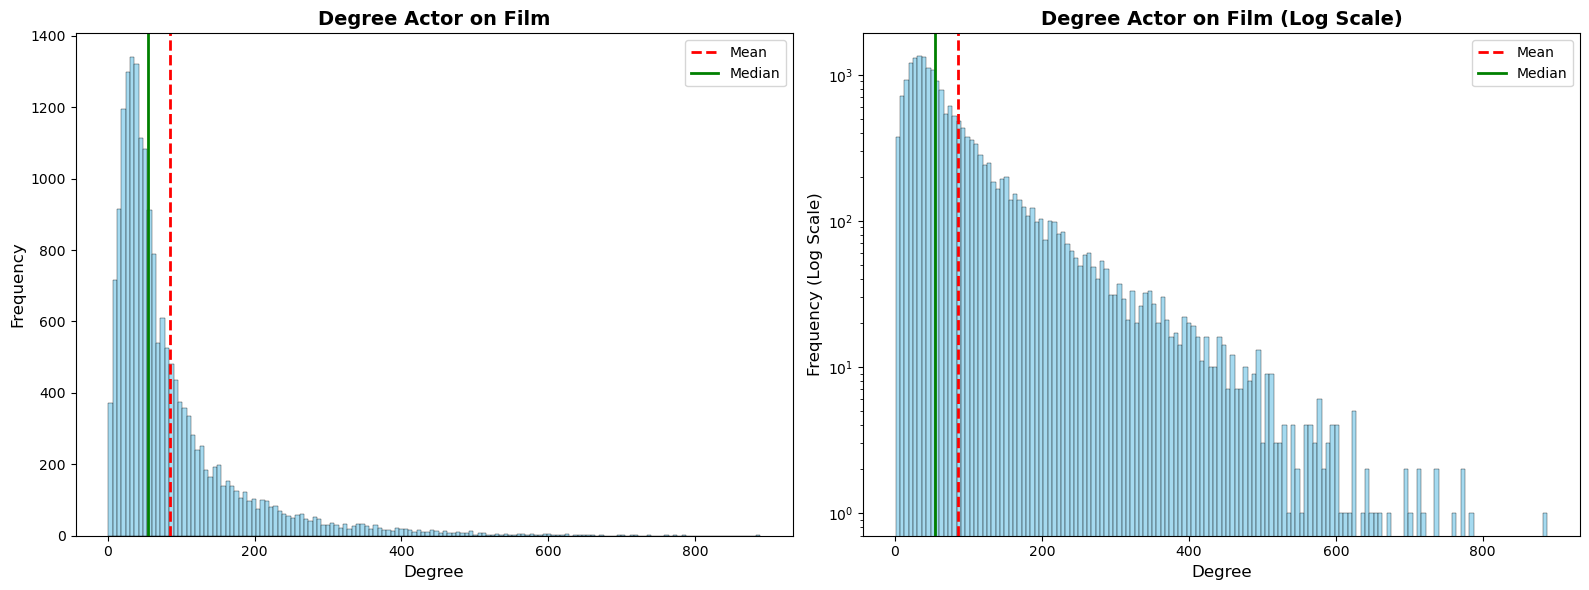

In [21]:
# Plotting the degree of actors from the network 
Plot_Degree_Actor(Actor_final)

As can be seen from the plot above, the data is heavily skrewed to the right. This will also be the case for most of the following plot throughout this notebook. Consequently, most of the plot had their y-axis log scaled.</br>
In order to put this number into perspective, we can compute the average number of actors per movies and then multiply this number by the number of films played by each actor and see if this values is similar or not to the degree of an actor. Theoritically, it should be, as an actor gains an edge with another actor for each movie they played together.  

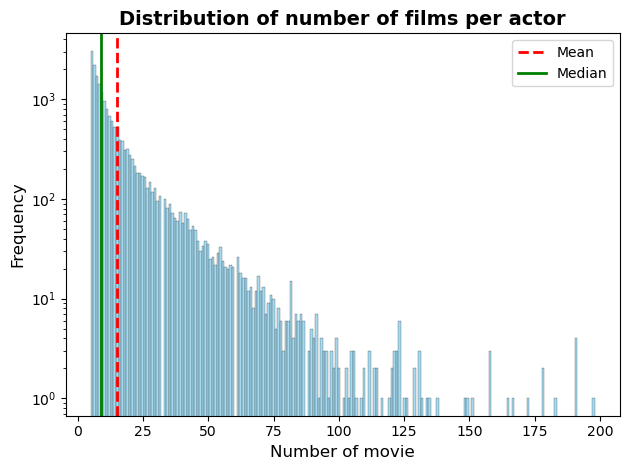

Describe of the degree of actor on film
count    18951.000000
mean        85.490159
std         88.505764
min          1.000000
25%         32.000000
50%         55.000000
75%        104.000000
max        888.000000
Name: Degree_final, dtype: float64
--------------
Describe of the number of films per actor
count    18967.000000
mean        14.857120
std         16.689924
min          5.000000
25%          6.000000
50%          9.000000
75%         17.000000
max        791.000000
Name: Number_of_films, dtype: float64


In [22]:
# Plotting the number of films per actor (only for actors with less than 200 movies)
# This also print a describe of the columns 'Number of films' and 'Degree' to commpare their relation
Plot_NOF_Actor(Actor_final,max_movie=200,describe=True)

We only plot the people with less than 200 films played or directed as there are outliers with almost 800 movies played. As can be seen from the describe of the actor above, the mean is is almost equal to 75 % quartile. This is due to the outliers (the maximum is 791) and the fact that the actors with less than 5 movies were not taken into account (they represented 85% of the original datasets). We can now analyse the relationship between degree of an actor and the mean number of movies per actor and the mean number of actors per movies.

In [23]:
# Printing the result of the analysis of the degree and the number of movie
Print_result_degree(Actor,Actor_final)

Mean degree of actor : 85.49
Mean number of actor per movie for all movies : 7.00
Mean number of movies per actor for all actors : 3.31
Mean number of movies per actor for actors that have played at least 5 movies : 14.86
Median number of movies per actor for actors that have played at least 5 movies : 9
------------
Mean degree of actor divided by mean number of actor per movie for all movies : 12.22
Mean number of actor per movie for all movies multiplied by the mean number of movies per actor (5 movies) :103.93
Mean number of actor per movie for all movies multiplied by the median of the number of movies per actor (5 movies) : 62.96


As can be seen from the results above, by computing the mean number of movies played by actors by dividing the mean degree of actors by the mean number of actors per movie, we obtain 12.22. This number is below the mean number of movies played by actors, which is 14.77. However, by computing the expected degrees of an actor by multiplying the average number of movies for actors by the average number of actors per movies, we obtain 103.93 which is far superior of the actual average of 85.49. </br>
Finally, it was decided to keep the actors which played in at least 12 movies. The mean of 14.86 seems to be too strict as it is greatly influenced by outliers. Hence, as 12.22 is a combinaison of the mean degrees of actors and the mean number of number of actor per movies, this is a good balance between imposing a minimal number of movies and of "connections" in the film industry.

### 3.2 Eigenvector centrality

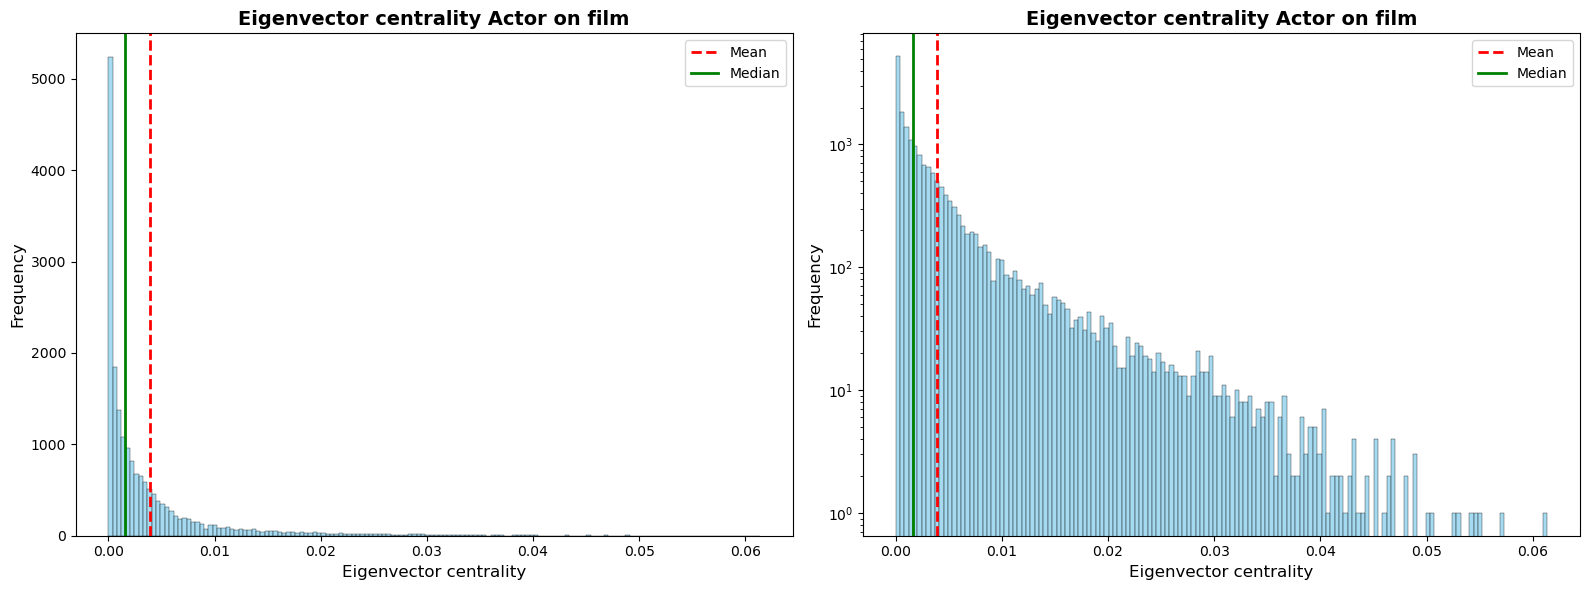

Describe of the eigenvector centrality of actor on film
count    1.895100e+04
mean     3.876901e-03
std      6.143232e-03
min      5.566486e-47
25%      3.370480e-04
50%      1.611171e-03
75%      4.521224e-03
max      6.138195e-02
Name: eigenvector_centrality_final, dtype: float64


In [24]:
# Plotting the actor eigenvector centrality as well as a describe of theses values
Plot_Centrality_Actor(Actor_final,describe = True)

The values of the eigenvector centrality are really small. The mean is almost 0.0038 and the median 0.00158 for actors with at least 5 movies. Even by taking into account only the actors which played in at least 50 movies, the values did not changed significantly. A potentiel explanation is the fact that, as seen previously from the adjacency matrix in section 2.1, the network is subdivided into two regions (dire as was seen dans la partie d'émile que ça peut être plusieurs clusters). This two regions are the European/American film industry and the Indian film industry. Both are communities that are large in size but never or rarely work together. Consequently, the overall eigenvector is low. 


A possible fix to this problem would be to separate the networks into multiple networks and compute the centrality of each of the networks and to keep the centrality above a certain value (relative to its network). Later on, the criteria on the eigenvector centrality would be applied separately on each region in order to determine which actor is successful.</br>
This method was tried by separating the networks but was not successful, it was then decided to try Louvain method to determine communities among the networks.

In [25]:
# Computing the community of the network of actors
actors_clustered, largest_clusters = Splitting_Louvain(played_together,Actor_final,random_state=0)

# Computing the centrality of each actors with respect to their community and their separeted network
Actors_Groups, Networks = Centrality_Louvain(actors_clustered,largest_clusters,Movie)

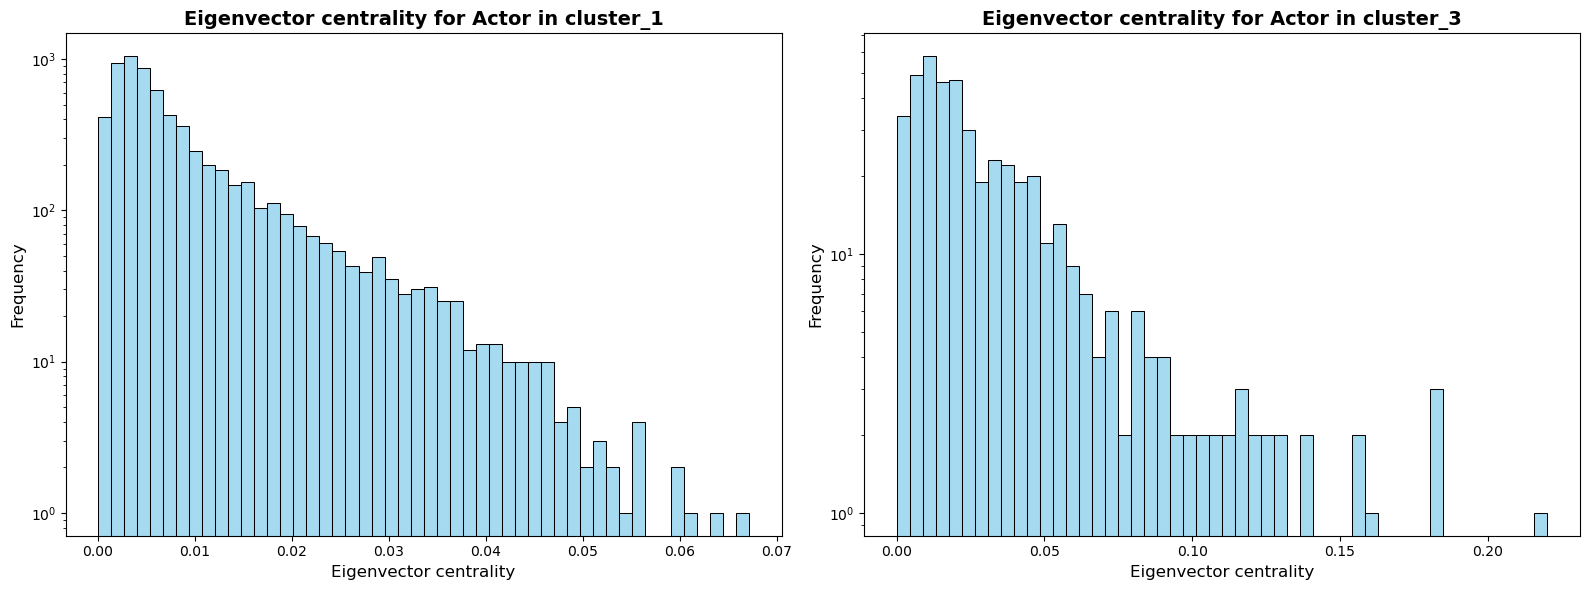

In [26]:
# Plotting the centrality for two clusters of the Louvains method
Plot_Centrality_Louvain_Actor(Actors_Groups,Cluster1='cluster_1',Cluster2='cluster_3',save=False)

As can be seen from above, the eigenvector centrality did change for some of the communities but not for all. This is still better than just taking the top 50% centrality or the values above the mean. Indeed, as we have a "relative" centrality, we take into account the people which are the best among their close circle of actors. Nevertheless, we should verify what actors will be dropped. If in the end, a community of only successful actors was build and we drop 50% of it, it does not make sense with our study. 

In [27]:
# Computing the actors that are above the mean or the median of the eigenvector centrality of all actors
Keep_Mean, Keep_Median = Eigenvector_Mean_Median(Actor_final)

In [28]:
# Computing the actors that are above the mean centrality of their community made by Louvain's method
Top_Louvain_Centrality = Top_centrality_Louvain(Actors_Groups)

In [29]:
# Printing and the comparing the result for each of the previous method :
# Above the global mean, above the global median, above the mean of each community
Comparing_Mean_Median_Louvain(Keep_Mean,Keep_Median,Top_Louvain_Centrality)

Number of actors which are above the global mean of the eigenvector centrality : 5488
Number of actors which are above the global median of the eigenvector centrality : 9476
Number of actors which are above the mean of their community eigenvector centrality : 6409
------------
Number of actors which are above the global mean but not above their community mean :
Freebase_actor_ID
True     3306
False    2182
Name: count, dtype: int64
------------
Number of actors which are above the global median but not above their community mean :
Freebase_actor_ID
False    5184
True     4292
Name: count, dtype: int64
------------
Number of actors which are above their community mean but not above the global median :
Freebase_actor_ID
True     4292
False    2117
Name: count, dtype: int64


As can be seen from the results above, around 40% of actors which were above the global mean of the centrality are not above the mean of their community. This is a problem, the Louvain method potentially created communities of "succesful" actors, hence half of those were drop in the process. Consequently, it was decided to take the global mean as a criteria, instead of the mean per communities.

### 3.3 Ratings and genres

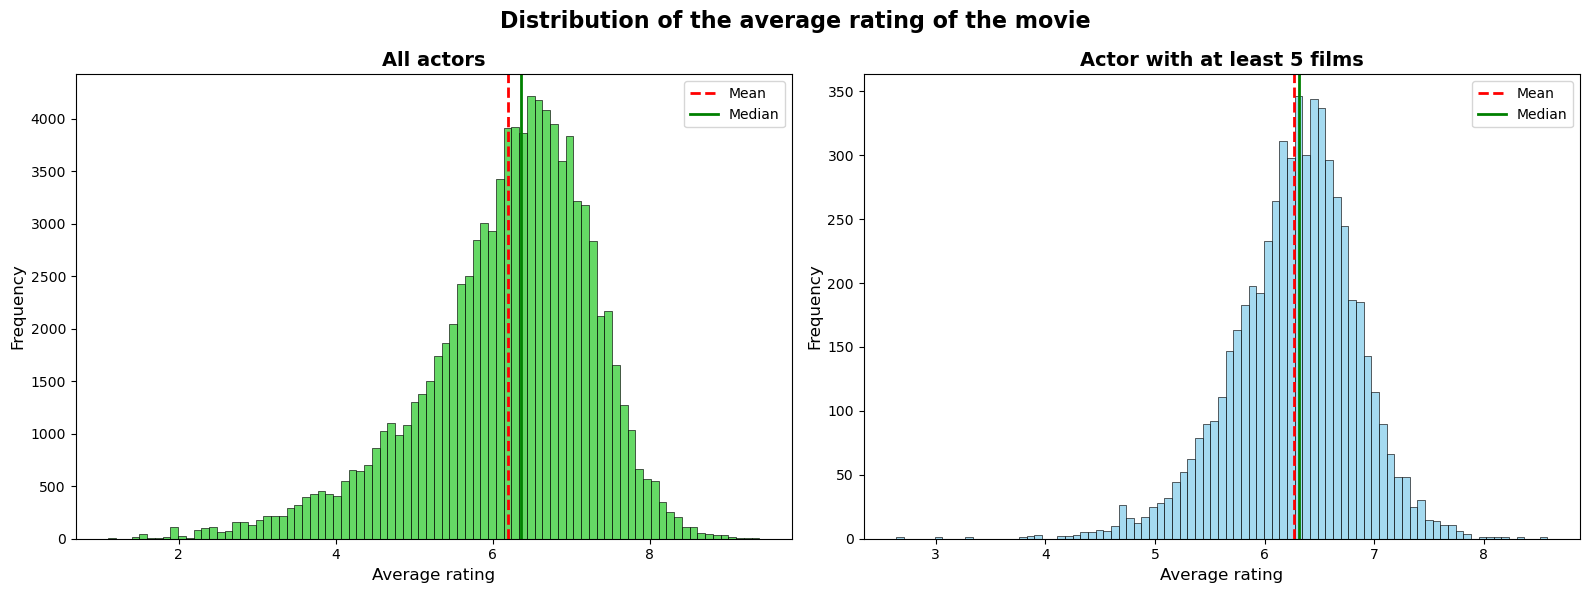

Describe of the actor rating for all actors
count    95338.000000
mean         6.193567
std          1.107457
min          1.100000
25%          5.600000
50%          6.366667
75%          6.982955
max          9.400000
Name: Mean_Rating, dtype: float64
------------
Describe of the actor rating for actors with more than 5 movies
count    5863.000000
mean        6.270170
std         0.564093
min         2.640000
25%         5.937500
50%         6.316667
75%         6.634314
max         8.580000
Name: Mean_Rating, dtype: float64


In [30]:
# Plot the mean rating of all actors and the mean rating of actor with at least 5 films
# Print a describe of the mean_rating columns of each dataframe
Plot_Mean_Rating_Actor(Actor_copy,Actor_final,save=False)

It is interesting to notice that by taking into account only the actors with at least 5 movies, the ratings concentrate their values around the mean as there are leass rating above 7 and especially almost none below 5. This suggest that actors throughout their career have up and downs. Indeed, as they have done more films, their average ratings "stabilize" around the mean/median, as expected from a large number of films.</br>
Moreover, actors with longer careers, as expected, have better and more constant ratings. Indeed, 50% of the ratings are between 5.93 and 6.63. The mean and the median are closer also while only taking actors with more than 5 films. This motivate once more the fact to drop actors with less than a certain amounts of movies.

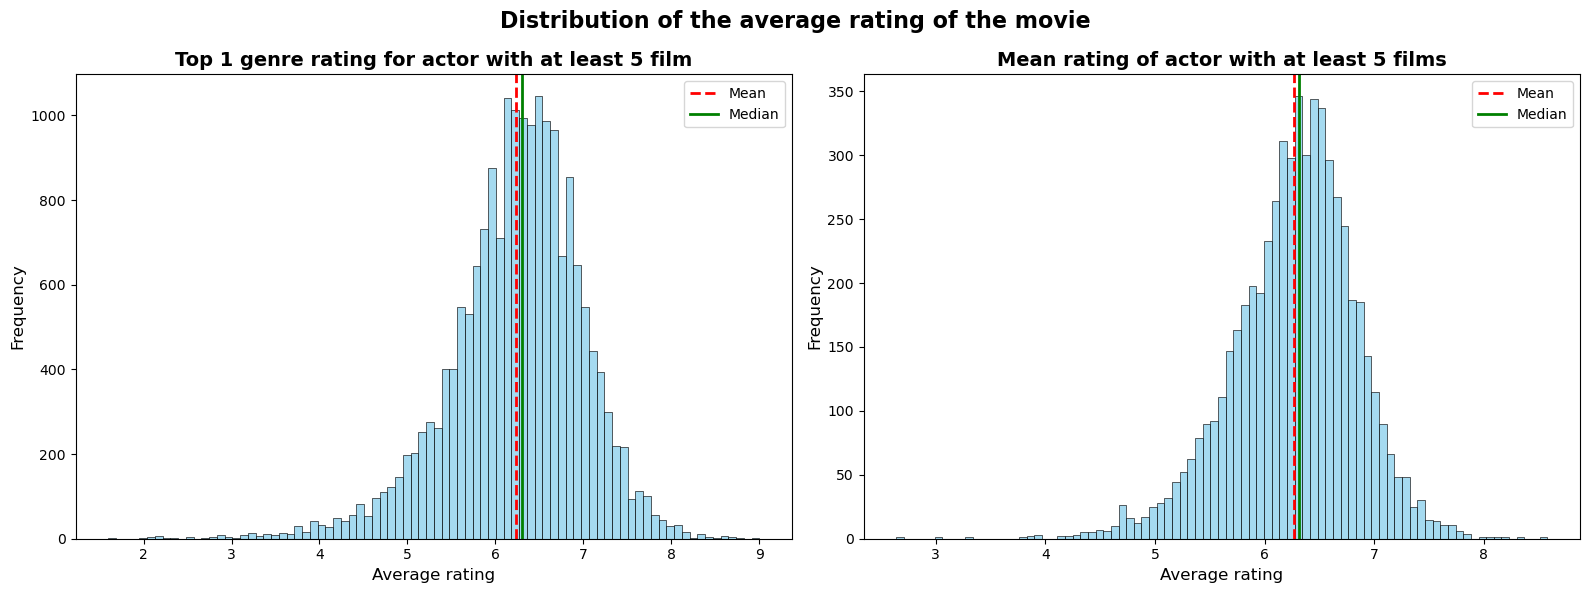

Mean of ratings of actor per genre : 6.234
Mean of ratings of actor : 6.270
Median of ratings of actor per genre : 6.300
Median of ratings of actor : 6.317


In [31]:
# Plotting and comparing the mean rating of actor and their average rating only in their top genre  
Plot_Top_1_Rating_Vs_Mean_Rating(Actor_final,save=False)

The graph are very similar as expected. Indeed, the median and the mean are similar in both cases. Nevertheless, they are in both cases lower than than if we took into account all the ratings of the actors. 

In [32]:
print(f"Describe of all genres : {Genre_counts['Average rating'].describe()}")
print('---------------')
print(f"Describe of genres with more than 200 movies : {Genre_counts_200['Average rating'].describe()}")

Describe of all genres : count    361.000000
mean       6.392463
std        0.646262
min        4.000000
25%        6.050000
50%        6.420000
75%        6.820000
max        8.100000
Name: Average rating, dtype: float64
---------------
Describe of genres with more than 200 movies : count    94.000000
mean      6.263484
std       0.474508
min       4.495300
25%       6.031623
50%       6.311633
75%       6.521556
max       7.285877
Name: Average rating, dtype: float64


A similar observation can be made for the genre. By taking into account less genre, the overall ratings concentrate around 6 to 6.5. In addition to that, the mean drop by 0.13 and the median by 0.11 which is also interesting. 

### 3.4 Determine the successfull actors

Now that the metrics were anaysed, we can finally determine the criteria that we will used to decide if an actor is successful or not. This criteria are of course arbitrary an if more/different information were available, they would potentially have changed. Here is the list :
- Edge and number of films per actor : actors which played in at least 12 movies will be kept.
- Ratings : actors wich are above the average ratings of their genre will be kept.
- Centrality : actors wich are above the mean centrality of all actors will be kept.

As a consequence, almost half of the actors, even more potentially, will be dropped. This was to be expected and necessary, as the successful actors shoudl theoritically only be among the top 5% of all actors. Indeed, at the beginning we dropped 85% of the actors that we originally had, hence only keeping 15%. By dropping more than half of the remaining actors, we will keep the top 5%. This top 5% is arbitrary, as explained previously, it depends on our expectations of what is successful. For our group, being successful means being in the top, even by taking 5% we may be laxist as we could only take the top 1%. However, as our dataset only contains 80'000 films and 135'000 which do not represent the millions of films that have been made, we can not be sure that we do not already have a pre-process dataset of "successfull movies", hence keeping more is a valid choice. In addition to that, the less actors we keep, the less data we have to analyse.

In [33]:
# Applying the criteria on the Rating
Actor_TOP_RATING, keep = keep_above_mean_rating(Actor_final,Genre_counts_200)
print(f"{Actor_final.shape[0]-Actor_TOP_RATING.shape[0]} actors are dropped due to their average rating")

Checking their relative ranking: 18967it [01:02, 305.47it/s]

8238 actors are dropped due to their average rating


In [34]:
# Applying the criteria on the number of film 
Actor_12_MOVIES = Actor_final[Actor_final['Number_of_films'] >= 12]
print(f"{Actor_final.shape[0]-Actor_12_MOVIES.shape[0]} actors are dropped due to the number of films played")

11367 actors are dropped due to the number of films played


In [35]:
# Applying the criteria on the centrality
Actor_TOP_Mean_centraty, _ = Eigenvector_Mean_Median(Actor_final)
print(f"{Actor_final.shape[0]-Actor_TOP_Mean_centraty.shape[0]} actors are dropped due to their centrality")

13479 actors are dropped due to their centrality


In [36]:
# Printing the results and the comparison of the differnet criteria 
Print_Comparison_Success(Actor_12_MOVIES, Actor_TOP_Mean_centraty, Actor_TOP_RATING)

Actors which have played 12 films and are (or not) above their genre average rating:
Freebase_actor_ID
True     4475
False    3125
Name: count, dtype: int64
------------
Actors above the global mean average and are (or not) above their genre average rating:
Freebase_actor_ID
True     3092
False    2396
Name: count, dtype: int64
------------
Actors above the global mean average and have (or not) played in at least 12 films:
Freebase_actor_ID
True     3961
False    1527
Name: count, dtype: int64


In [37]:
# Compiling each of the different criteria
Actor_Success = keep_successful_actor(Actor_final, Genre_counts_200)
print(f"In total there is {Actor_Success.shape[0]} which are successful based on our criteria.")
print(f"This reprensents {Actor_Success.shape[0]/Actor.shape[0]:.2%} of the total number of original actors.")

Checking their relative ranking: 18967it [01:01, 308.37it/s]


In total there is 2309 which are successful based on our criteria.
This reprensents 1.70% of the total number of original actors.


Computation time:5.41


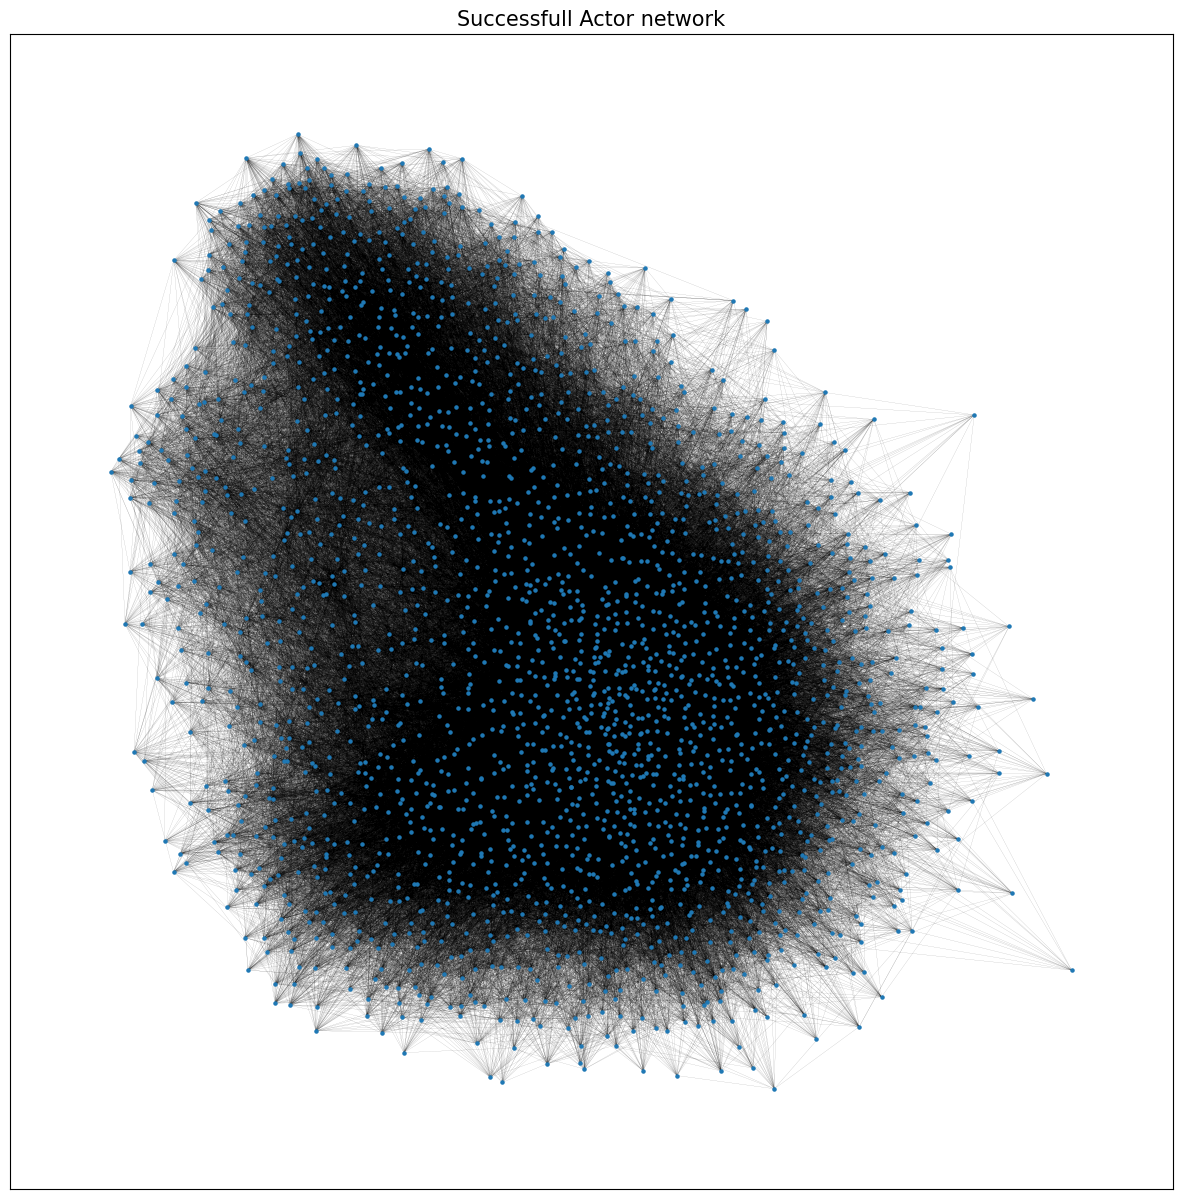

Time to compute: 21.3 seconds


In [38]:
# Creating the network only between the successful actors and plotting it
played_together, _ = Create_Network_Actor_and_Attribute(Actor_Success,Movie,min_movie=10)
plot_Success_actor_network(played_together, k=0.1, seed=42)

## 4. Actors and directors networks

Now that the selection fo successful actors was made based on the different criteria, it is possible to create the bipartite directed graph between them and the director. The objective will be to create a bipartite directed that begin from the actors and go to the directors. A edge between an actor and a director is only possible if they worked together and the weight of the edge represent the number of films on which they worked together. The final value at the node of each director is the sum of the weight of all edges coming to him. 

In [39]:
# Create the bipartite directed graph 
Di_B_network = Create_Bipartite_Director(Actor_Success, Director, min_movies=10)

Bipartite graph generated successfully!


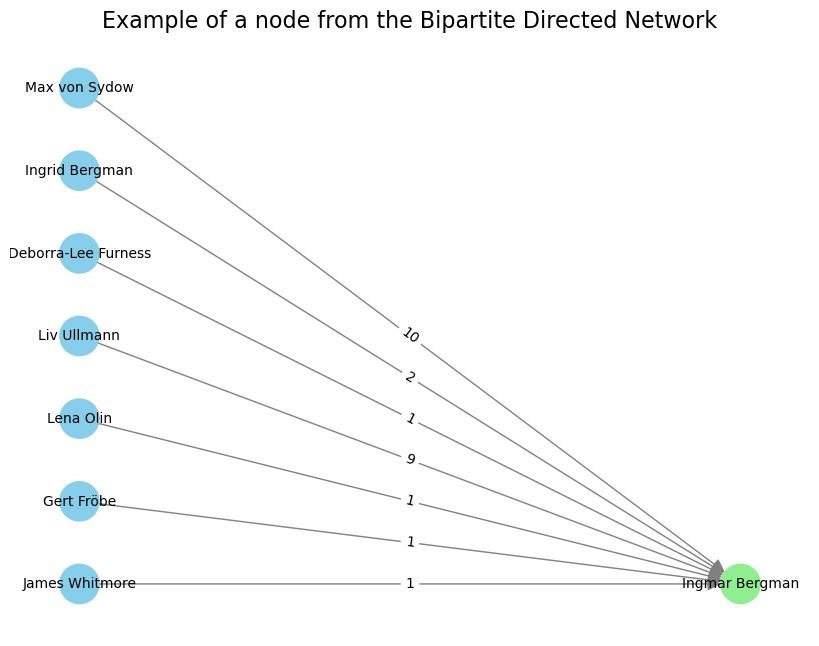

In [40]:
# Plotting the directed bipartite for a single Director (example)
Plot_Subgraph_Directed_Graph(Di_B_network,Director, director_name='Ingmar Bergman', save=False)

In [41]:
# Computing the director which result from the network and adding their attributes to their profile
# Adding Weight, Total_Weight and the list of successful wich worked with them
Director_Success = director_success1(Di_B_network, Director)
Director_Success[['IMDb_director_ID','director_name','Freebase_actor_ID','Number_of_actors','Weight','Sum_Weight']].head()
print(f"Total number of director that are linked to successful actors : {Director_Success.shape[0]}")

Total number of director that are linked to successful actors : 7555


## 5. Kmeans and determining type of directors

We will now determined the most highly valued director and then performed a Kmeans algorithm to determine different types of director based on their characteristics.

In [42]:
# Printing the results
Director_Success[['IMDb_director_ID','director_name','Freebase_actor_ID','Number_of_actors','Weight','Sum_Weight']].head()

IMDb_director_ID     director_name  \
0        nm0000005    Ingmar Bergman   
1        nm0000008     Marlon Brando   
2        nm0000009    Richard Burton   
3        nm0000018      Kirk Douglas   
4        nm0000019  Federico Fellini   

                                   Freebase_actor_ID  Number_of_actors  \
0  [/m/04r7p, /m/01y64_, /m/0bdt8, /m/05r751, /m/...                 7   
1  [/m/04__f, /m/0js45, /m/028lc8, /m/01y8cr, /m/...                 5   
2                               [/m/0bmh4, /m/0cg9f]                 2   
3  [/m/01rnxn, /m/0j582, /m/0n7f, /m/0bj9ts, /m/0...                 6   
4  [/m/0ywqc, /m/013sg6, /m/01fkv0, /m/05vjms, /m...                17   

                                              Weight  Sum_Weight  
0                             [9, 1, 2, 1, 1, 10, 1]          25  
1                                    [1, 1, 1, 1, 1]           5  
2                                             [1, 1]           2  
3                                 [1, 1, 1, 1, 1, 1]           6  
4  [1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, ...          23

In [43]:
# Checking which information are available or not for the Kmeans
Director_Success.isna().sum()

IMDb_director_ID           0
director_name              0
birthYear_director      2111
deathYear_director         0
Freebase_movie_ID          0
age_at_movie_release       0
Career_Start_age        2162
Number_of_films            0
Ratings                    0
Mean_Rating              287
Top_1_Genre                0
Top_1_Number               0
Top_1_Rating              18
Freebase_actor_ID          0
Weight                     0
Sum_Weight                 0
Number_of_actors           0
dtype: int64

In order to perform the Kmeans, we must first decide on which information the Kmeans will be applied. As can be seen from above, the birthyear and the career_start_age are not determined for a major part of the database (25% approximately), hence this information will not be taken into account for the Kmeans. In addition to that, the director which their Mean_Rating is not determined will be dropped. They represent a little part of the whole list of director (287 out of 7555). 

Kmeans characteristics :
1) Mean_Rating 
2) Number_of_films
3) Sum_Weight
4) Number_of_actors


faudrait refaire avec le career start age ou birth year et voir si ça change

In [44]:
# Computing the updated dataset of director and preparing it for the kmeans algorithm by scaling it
Director_dataset, Director_dataset_std = prepare_director_dataset_Kmeans(Director_Success)

# Applying the elbow method to determine the best number of cluster
plot_elbow_method_Director(Director_dataset_std,range(1,11),random_state = 0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 60.39it/s]


As can be seen from the plot above, the elbow method indicates that after 4 clusters, the SSE decreased at a less quick rate. Consequently, it was chosen to select 4 as the number of total clusters. We also tried doing the same process with 3 clusters, however 4 gaves us better results and the different types of director were more subtile. Indeed, with 4 clusters, some clusters had simial characteristics but were very different on specific point which was interesting. These observations and conclusions will be shown in the next section.

In [45]:
# Applying the Kmeans and labelling each director
Director_Success_Kmeans = Kmeans_clustering_director(Director_Success, Director_dataset_std, 4, random_state=0)
print('Distribution of the number of diretors per labels :')
Director_Success_Kmeans['Cluster_Label'].value_counts()

Distribution of the number of diretors per labels :


Cluster_Label
3    3998
2    2450
0     689
1     131
Name: count, dtype: int64

## 6. Analyse and compare the directors between them

In this section, we will compare the previously selected directors. Multiple parameters will be used such as weight, total weight, number of successful actors, number of movie directed, average ratings of them and their actors, etc.</br>
The goal will then be to analyse to similarities and differences and finally to define different type of directors based on our findings and on the clustering. In addition to that, the link between these directors and the successful actors will also be investigate. 

In [46]:
print(f"Total number of director after the clustering method : {Director_Success_Kmeans.shape[0]}")

Total number of director after the clustering method : 7268


In [47]:
# Plotting the distribution adn ciount in each cluster
Plot_Camembert_Kmeans(Director_Success_Kmeans,save=False)

In [48]:
# Plot the total weight of each director by cluster
Plot_Weight_Director(Director_Success_Kmeans,save=False)

In [49]:
# Plot the distribution of the weight of edges and the number of edges (Actors) per director
Plot_Edge_Weight_Distribution(Director_Success_Kmeans,save=False)
Plot_Number_of_Edges(Director_Success_Kmeans,save=False)

In [50]:
# Computing the distribution of weight of each edge over all directors (not by clusters)
weights_edge = Count_Edge_Distribution(Director_Success_Kmeans)
weights_edge

Weight  Occurrences
1        1        47786
2        2         3646
9        3          844
8        4          318
4        5          113
12       6           73
10       7           40
6        8           23
0        9           19
3       10            7
5       11            5
13      12            1
17      13            3
16      14            3
7       16            1
11      18            1
18      22            1
15      24            1
19      25            1
14      28            1

In [51]:
# Plot the mean rating of each director by cluster
Plot_Mean_Rating_Director_Cluster(Director_Success_Kmeans,save=False)

In [52]:
# Plot the birth of year of each director per cluster
Plot_BOY_Director_Cluster(Director_Success_Kmeans)

In [53]:
# Plot the career start age of each director by cluster  
Plot_Career_Start_Director_Cluster(Director_Success_Kmeans,save=False)

In [54]:
# Plot the number of films for each director by cluster with a limit of 100 movies maximal
Plot_NOF_Director_Cluster(Director_Success_Kmeans, Max_movie=100, save=False)

In [55]:
# Plot Number of films versus the Total weight for each director by Cluster
Plot_NOF_Vs_Sum_Weight(Director_Success_Kmeans, save=False)

In [56]:
# Scatter plot of the number of actors versus the total weight of each directors by Cluster
Plot_NOA_Vs_Sum_Weight_Director_Cluster(Director_Success_Kmeans,save=False)

In [57]:
# Plot of the number of films versus the career start age per Dircetor by clusters
Plot_NOF_Vs_Career_Start(Director_Success_Kmeans,Max_movie=100,save=False)

## 7. Specific analysis of a director per labels

4 different labels were determined with the help of the Kmeans algorithm. Each of them were plot for multiple different factors in the last section. This helped determine the characterics of each of them as well as their similarities. The 4 labels can be summarized as :
- Cluser 2 - **Bad directors** : The directors in this cluster are not good at what they do. They made a few movies and in addition to that, their ratings were not above the average. Nevertheless, they still manage to make movies with some successful actors but not that many. They have a low total weight. 
- Cluser 3 - **"Few movies but high ratings" Directors** : They have a low total weight compared to cluster 0 and 1, meaning that they have not that much directed successfull actors. They have as well having directed less movies than in clutster 0 and 1. In these two aspect, these directors are similar to the directors in cluster 2. However, they have a high rating, like in cluster 0 and 1. 
- Cluser 0 - **"Lot movies and good ratings" Directors** which had prolific careers with and without successful actors. Their total weight is not that high but their ratings are good nonetheless. They made a lot of movies and have an overall hihg ratings. However, compared to the cluster 1, they tend to have worked with less successfull actors.
- Cluser 1 - **"Lot movies and good ratings" Directors + Successful Actors** : Like for cluster 0, they also had prolific career as they made a lot of high rated movies but most of the movies contains successful actors. Consequently, they have a really high weight compared to the others clusters.

We will now analyse a selection of a few directors which are part of each cluster in order to better understand their characteristics and difference.

In [58]:
# Create the database that only contains the selected directors
Director_highlight = Create_Director_Cluster_Highlight(Director_Success_Kmeans)

In [59]:
Director_highlight[Director_highlight['Cluster_Label']==0]

IMDb_director_ID  director_name  birthYear_director deathYear_director  \
827          nm0005196  Paul Mazursky              1930.0               2014   
7192         nm0413875   Mick Jackson              1943.0               None   
10000        nm0588183   David Miller              1909.0               1992   

                                       Freebase_movie_ID  \
827    [/m/04x1t3, /m/0941nw, /m/080hdv7, /m/015qtl, ...   
7192   [/m/095_8f, /m/04066p, /m/0258dh, /m/0ck_1y, /...   
10000  [/m/0dn17z, /m/0fw92r, /m/0ddb6bk, /m/09rlntx,...   

                                    age_at_movie_release  Career_Start_age  \
827    [39, 40, 43, 44, 46, 48, 50, 52, 54, 56, 58, 5...              39.0   
7192                            [46, 48, 49, 51, 54, 59]              46.0   
10000  [32, 33, 33, 40, 41, 42, 43, 47, 47, 48, 50, 5...              32.0   

       Number_of_films                                            Ratings  \
827                 15  [6.7, 5.4, 6.2, 7.3, 7.0, 7.2, 5.9, 6.4, 6.5, ...   
7192                 6                     [6.3, 6.7, 6.4, 5.7, 5.5, 5.5]   
10000               20  [5.7, 6.7, 5.7, 6.1, 6.7, 6.3, 7.5, 6.1, 6.1, ...   

       Mean_Rating Top_1_Genre Top_1_Number  Top_1_Rating  \
827       6.186667       Drama           13      6.360000   
7192      6.016667      Comedy            4      5.966667   
10000     6.225000      Comedy           16      6.100000   

                                       Freebase_actor_ID  \
827    [/m/0htlr, /m/02qx5h, /m/01y64_, /m/0p_pd, /m/...   
7192   [/m/05fnl9, /m/0krsjq, /m/07nvq1, /m/03pmzt, /...   
10000  [/m/0j582, /m/033231, /m/01csrl, /m/03xx3m, /m...   

                                                  Weight  Sum_Weight  \
827    [1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, ...          46   
7192   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...          33   
10000  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...          49   

       Number_of_actors  Cluster_Label  
827                  42              0  
7192                 32              0  
10000                48              0

In [60]:
Director_highlight[Director_highlight['Cluster_Label']==1]

IMDb_director_ID      director_name  birthYear_director deathYear_director  \
25        nm0000095        Woody Allen              1935.0               None   
76        nm0000229   Steven Spielberg              1946.0               None   
79        nm0000233  Quentin Tarantino              1963.0               None   

                                    Freebase_movie_ID  \
25  [/m/05hb3b, /m/01rn7k, /m/04t6jm, /m/0564gy, /...   
76  [/m/0kv8sl, /m/05k8zz, /m/0jyb4, /m/012mrr, /m...   
79  [/m/02h4658, /m/0f4_l, /m/02pg45, /m/0234j5, /...   

                                 age_at_movie_release  Career_Start_age  \
25  [31, 34, 36, 37, 38, 40, 42, 43, 44, 45, 47, 4...              31.0   
76  [18, 28, 29, 31, 33, 36, 37, 38, 39, 41, 43, 4...              18.0   
79   [29, 31, 32, 34, 24, 46, 42, 44, 44, 49, 40, 41]              24.0   

    Number_of_films                                            Ratings  \
25               42  [5.8, 7.2, 6.9, 6.7, 7.1, 7.6, 8.0, 7.3, 7.8, ...   
76               28  [5.5, 6.7, 8.1, 7.6, 5.8, 7.9, 6.4, 7.5, 7.7, ...   
79               12  [8.3, 8.9, 6.7, 7.5, 5.5, 8.4, 8.0, 7.5, 7.0, ...   

    Mean_Rating Top_1_Genre Top_1_Number  Top_1_Rating  \
25     7.028571       Indie           35      7.100000   
76     7.303571   Adventure           17      7.241667   
79     7.708333       Drama            9      8.225000   

                                    Freebase_actor_ID  \
25  [/m/08k7kb, /m/07628l, /m/01713c, /m/03f0757, ...   
76  [/m/02s_qz, /m/05fnl9, /m/08sz0k, /m/03jqw5, /...   
79  [/m/04mqnp, /m/073x6y, /m/02nwxc, /m/0fd16g, /...   

                                               Weight  Sum_Weight  \
25  [1, 1, 1, 1, 3, 1, 1, 1, 1, 5, 1, 6, 1, 1, 1, ...         302   
76  [1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...         192   
79  [2, 2, 1, 2, 1, 1, 1, 1, 3, 1, 1, 1, 1, 2, 1, ...         108   

    Number_of_actors  Cluster_Label  
25               204              1  
76               165              1  
79                76              1

In [61]:
Director_highlight[Director_highlight['Cluster_Label']==2]

IMDb_director_ID           director_name  birthYear_director  \
11518        nm0684719          Ernest Pintoff              1931.0   
13334        nm0794791            Jack Sholder              1945.0   
15308        nm0926211  Preston A. Whitmore II              1962.0   

      deathYear_director                                  Freebase_movie_ID  \
11518               2002  [/m/027df76, /m/0cc91pl, /m/0fyftv, /m/0fp46l,...   
13334               None  [/m/0bh4wr, /m/08mczf, /m/0c01vd9, /m/026vskz,...   
15308               None                [/m/027xtd9, /m/0fymw0, /m/02xbnkx]   

               age_at_movie_release  Career_Start_age  Number_of_films  \
11518          [40, 48, 50, 50, 41]              40.0                5   
13334  [37, 40, 42, 44, 55, 57, 56]              37.0                7   
15308                  [33, 44, 45]              33.0                3   

                                   Ratings  Mean_Rating Top_1_Genre  \
11518            [6.0, 4.2, 4.7, 6.1, 4.9]         5.18      Comedy   
13334  [6.0, 5.5, 7.0, 5.4, 4.8, 4.4, 4.0]         5.30    Thriller   
15308                      [4.9, 2.2, 6.4]         4.50      Sports   

      Top_1_Number  Top_1_Rating  \
11518            3          5.20   
13334            5          5.52   
15308            3          2.20   

                                       Freebase_actor_ID  \
11518       [/m/06_qlq, /m/07km4n, /m/015qt5, /m/0131kb]   
13334  [/m/08ztf1, /m/02bsm, /m/02t901, /m/0jtmgh, /m...   
15308  [/m/029_l, /m/055tnj, /m/08s7t9, /m/05mc99, /m...   

                                           Weight  Sum_Weight  \
11518                                [1, 1, 1, 1]           4   
13334  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1]          15   
15308                    [1, 1, 2, 1, 1, 1, 1, 1]           9   

       Number_of_actors  Cluster_Label  
11518                 4              2  
13334                14              2  
15308                 8              2

In [62]:
Director_highlight[Director_highlight['Cluster_Label']==3]

IMDb_director_ID    director_name  birthYear_director  \
7386         nm0425328      Jed Johnson              1948.0   
12059        nm0714853    James Redford              1962.0   
12932        nm0772095  Thomas Schlamme              1950.0   

      deathYear_director                   Freebase_movie_ID  \
7386                1996                         [/m/08yjqn]   
12059               2020                        [/m/0b3vkz_]   
12932               None  [/m/026g1hd, /m/01f50k, /m/09jwj8]   

      age_at_movie_release  Career_Start_age  Number_of_films  \
7386                  [29]              29.0                1   
12059                 [41]              41.0                1   
12932         [39, 43, 44]              39.0                3   

               Ratings  Mean_Rating     Top_1_Genre Top_1_Number  \
7386             [6.0]          6.0    Black comedy            1   
12059            [6.3]          6.3  Romantic drama            1   
12932  [6.1, 6.5, 6.6]          6.4    Crime Comedy            3   

       Top_1_Rating                                  Freebase_actor_ID  \
7386            6.0                             [/m/01b17y, /m/02hmn8]   
12059           6.3                            [/m/01mm7j9, /m/02bj6k]   
12932           6.5  [/m/01nr36, /m/015grj, /m/030b93, /m/01kp66, /...   

                                                  Weight  Sum_Weight  \
7386                                              [1, 1]           2   
12059                                             [1, 1]           2   
12932  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...          20   

       Number_of_actors  Cluster_Label  
7386                  2              3  
12059                 2              3  
12932                19              3